In [ ]:
## Import relevant modules
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dog_epidemic.Utils as utils
from datetime import date
import numpy as np
import shapely
from shapely import Point
from shapely import Polygon
import random
import geopandas as gp
import geoplot as gpplt
import math
import numpy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import cv2
import os
from PIL import Image
import tqdm



In [2]:
## Set the input data for dogs that are eligible to be infected.
all_dogs = gp.read_parquet('CurrentNYCPuppies.parquet')

In [ ]:
## Set experiment parameters and location to save experiment outputs
starting_zipcode = 11368
n_initially_infected = 3
n_generation_intervals = 25
distance = 0.04
buffer = 0.009
max_exposed_per_dog = 25
density_factor = 0.2
p_recovery = 0.05
p_detection = 0.35
quarantine_on_threshold = 200
quarantine_off_threshold = 100
quarantine_reduction = 0.50
experiment_name = 'Narrow_Walks'
image_folder = os.path.join(experiment_name, 'Figures')
reports_folder = os.path.join(experiment_name, 'Reports')
gif_folder = os.path.join(experiment_name, 'GIFs')

In [5]:
## Run the experiment given the set inputs
SEIR_Report, R_report = utils.run_simulation(
    all_dogs = all_dogs, 
    starting_zipcode = starting_zipcode, 
    n_initially_infected = n_initially_infected,
    n_generation_intervals = n_generation_intervals, 
    distance = distance, 
    buffer = buffer,
    max_exposed_per_dog = max_exposed_per_dog, 
    density_factor = density_factor,
    p_recovery = p_recovery,
    p_detection = p_detection,
    quarantine_on_threshold = quarantine_on_threshold, 
    quarantine_off_threshold = quarantine_off_threshold,
    quarantine_reduction = quarantine_reduction, 
    image_folder=image_folder, 
    subtitle = experiment_name)

Infections detected at generation 1: 2
Exposed dogs at generation 1 = 5
Dogs recovering at generation 2: 0
Infections detected at generation 2: 3
Exposed dogs at generation 2 = 11
Dogs recovering at generation 3: 0
Infections detected at generation 3: 5
Exposed dogs at generation 3 = 24
Dogs recovering at generation 4: 3
Infections detected at generation 4: 9
Exposed dogs at generation 4 = 55
Dogs recovering at generation 5: 1
Infections detected at generation 5: 23
Exposed dogs at generation 5 = 135
Dogs recovering at generation 6: 3
Infections detected at generation 6: 54
Exposed dogs at generation 6 = 243
Dogs recovering at generation 7: 11
Infections detected at generation 7: 99
Exposed dogs at generation 7 = 414
Dogs recovering at generation 8: 20
Infections detected at generation 8: 146
Quarantine activated: 146 detected dogs is above activation threshold of 100
Exposed dogs at generation 8 = 392
Dogs recovering at generation 9: 37
Infections detected at generation 9: 162
Exposed

In [6]:
## Save the experiment output reports as CSV files
os.makedirs(reports_folder, exist_ok=True)
SEIR_Report.set_index('Step').to_csv(os.path.join(reports_folder,'SEIR_report.csv'))
R_report.set_index('Step').to_csv(os.path.join(reports_folder,'R_report.csv'))

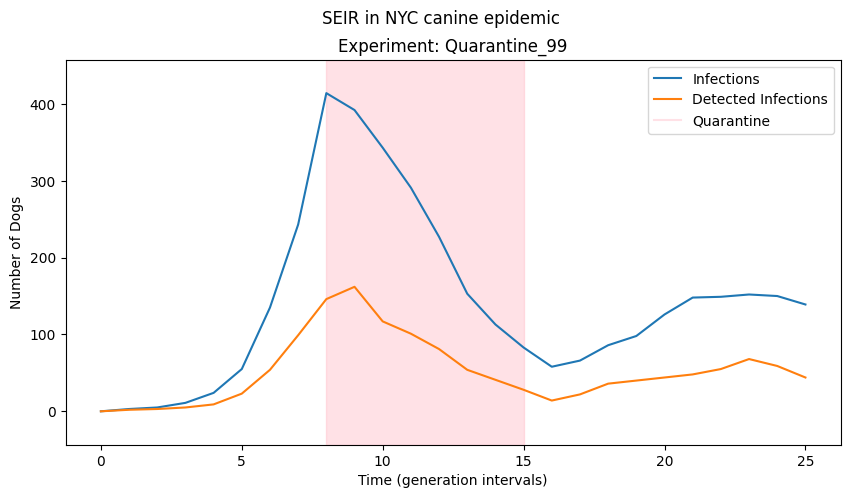

In [7]:
## Use the R report to creat a plot of infections over generation intervals
fig, ax = plt.subplots(figsize=(10, 5))
#plt.plot(range(n_generation_intervals + 1), SEIR_report['Susceptible'], label="Susceptible (S)")
plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Infected'], label="Infections")
plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Detected'], label="Detected Infections")
#plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Exposed'], label="Exposed (E)")
#plt.plot(range(SEIR_Report.shape[0]), SEIR_Report['Recovered'], label="Recovered (R)")
ax.fill_between(range(SEIR_Report.shape[0]), 0, 1, 
                where=SEIR_Report['Quarantine'], 
                alpha=0.4, color = 'lightpink',
                transform=ax.get_xaxis_transform())
plt.plot([], [], label='Quarantine', alpha = 0.4, color='lightpink')
plt.xlabel("Time (generation intervals)")
plt.ylabel("Number of Dogs")
plt.suptitle("SEIR in NYC canine epidemic")
plt.title('Experiment: ' + str(experiment_name))
plt.legend()
plt.show()
fig.savefig(os.path.join(image_folder,'SEIR_figure.png'), format= 'png')
plt.close()

In [8]:
## Use the R report to count up how many dogs are exposed at any given time step in each zipcode.
counts_of_exposed = R_report.groupby(['Step', 'Exposed_ZipCode'], as_index=False)['Count'].sum()
counts_of_exposed = counts_of_exposed.rename(columns={"Exposed_ZipCode": "ZipCode"})
all_dogs_count = all_dogs
all_dogs_count['Count'] = 1 
counts_all = all_dogs_count.groupby(['ZipCode', 'geometry'], as_index=False)['Count'].sum()


In [9]:
max_percent = 100
percent_exposed = pd.DataFrame()
percent_frame = 0

## Calculate the percent of dogs exposed in each zip code for each time step and create images
for step in tqdm.tqdm(range(counts_of_exposed['Step'].nunique())):
    counts_of_exposed_step = counts_of_exposed[counts_of_exposed['Step'] == step]
    counts_all['Step'] = step
    percent_exposed_step = pd.merge(counts_of_exposed_step.set_index('ZipCode'), 
                                counts_all.set_index('ZipCode'), 
                                on = ['ZipCode'], how = 'right',
                                suffixes = ('_exposed', '_all'),
                                indicator=True).drop(['_merge', 'Step_exposed'], axis = 1)
    percent_exposed_step['Count_exposed'] = percent_exposed_step['Count_exposed'].fillna(0)
    percent_exposed_step['percent_exposed'] = percent_exposed_step['Count_exposed']/percent_exposed_step['Count_all']*100
    percent_exposed = gp.GeoDataFrame(pd.concat([percent_exposed, percent_exposed_step], ignore_index=False))

    fig, ax = plt.subplots(1,1)
    fig.suptitle("Percent of Dogs Exposed at Generation " + str(step))
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    figname = os.path.join(image_folder,'percent_exposed' + str(percent_frame) + '.png')
    percent_exposed.plot(ax = ax, cax = cax, column = 'percent_exposed', cmap='RdPu', legend = True,
                         vmin = 0.0, vmax=max_percent, edgecolor = 'lightgray', linewidth = 0.25,
                         legend_kwds={"label": "Percent of Dogs Exposed", "orientation": "horizontal"},)
    plt.text(0.25, 14, 
             'Starting zipcode: ' + str(starting_zipcode) +
             '\nInitially infected: ' + str(n_initially_infected) +
             '\nDistance: ' + str(distance) +
             '\nBuffer: ' + str(buffer) +
             '\nMax exposure: ' + str(max_exposed_per_dog) +
             '\nDensity factor: ' + str(density_factor) +
             '\nRecovery: ' + str(p_recovery) +
             '\nExperiment: ' + str(experiment_name) +
             '\nQuarantine Reduction: ' + str(quarantine_reduction) +
             '\nDetection Rate: ' + str(p_detection),
             fontsize = 9)
    left, bottom, width, height = [0.13, 0.15, (step/n_generation_intervals)*0.77, 0.06]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.set_axis_off()
    ax2.set_ylim(0,SEIR_Report['Exposed'].max())
    ax2.plot(range(SEIR_Report.head(step).shape[0]), 
             SEIR_Report.head(step)['Exposed'], 
             label="Exposed (E)",
             color = 'purple',
             marker = '.',
             markersize = 0.5)
    if SEIR_Report.head(step)[SEIR_Report.head(step)['Quarantine'] == 1].shape[0] > 0:
        ax2.fill_between(range(SEIR_Report.head(step).shape[0]), 0, SEIR_Report['Exposed'].max(), 
                where=SEIR_Report.head(step)['Quarantine'], 
                alpha=0.4, color = 'lightpink')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    percent_frame = percent_frame + 1


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


In [10]:
## Create GIF out of state of the simulation images
os.makedirs(gif_folder, exist_ok=True)
images = [image_folder + f'/state_{i}.png' for i in range(n_generation_intervals * 3)]
images = [Image.open(image) for image in images]
gif_name = os.path.join(gif_folder, 'state_of_simulation.gif')
duration = 500 # duration per frame in milliseconds
images[0].save(gif_name, save_all=True, append_images=images[1:], duration=duration, loop=0)

In [11]:
## Create GIF out of the percent of dogs exosed images
os.makedirs(gif_folder, exist_ok=True)
images = [image_folder + f'/percent_exposed{i}.png'  for i in range(n_generation_intervals)]
images = [Image.open(image) for image in images]
gif_name = os.path.join(gif_folder, 'percent_exposed.gif')
duration = 500 # duration per frame in milliseconds
images[0].save(gif_name, save_all=True, append_images=images[1:], duration=duration, loop=0)